In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

import matplotlib.colors as clrs
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

%matplotlib nbagg

## 0. Sample data 생성
f = -x1 - x2 를 dicision boundary로 갖는 데이터를 생성한다

In [2]:
def data2d_create(center,num,r = 2):
    data = np.random.randn(num,2)*r
    data[:,0] = data[:,0] + center[0]
    data[:,1] = data[:,1] + center[1]
    return data

In [3]:
num_of_data = 100
class1=data2d_create((-5,-5),num_of_data)
class2=data2d_create((15,15),num_of_data)

class1=np.concatenate([class1,np.ones((num_of_data,1))],1)
class2=np.concatenate([class2,-np.ones((num_of_data,1))],1)

print(class1.shape,class2.shape)

(100, 3) (100, 3)


In [4]:
# class1[0][0] =-8000
# class1[0][1] = 1000 # -Y\*y vs Max(0,-Y\*y)

In [5]:
class1[:5]

array([[-3.87691922, -5.01119724,  1.        ],
       [-2.84964693, -5.35958804,  1.        ],
       [-9.31056659, -3.57699327,  1.        ],
       [-0.68965776, -2.69050704,  1.        ],
       [-1.16944334, -5.64294419,  1.        ]])

In [6]:
class2[:5]

array([[ 11.81552411,  15.13256338,  -1.        ],
       [ 15.48439007,  19.19078185,  -1.        ],
       [ 16.29313684,  11.93798585,  -1.        ],
       [ 14.0292658 ,  12.57333477,  -1.        ],
       [ 12.90191881,  16.39648722,  -1.        ]])

<IPython.core.display.Javascript object>


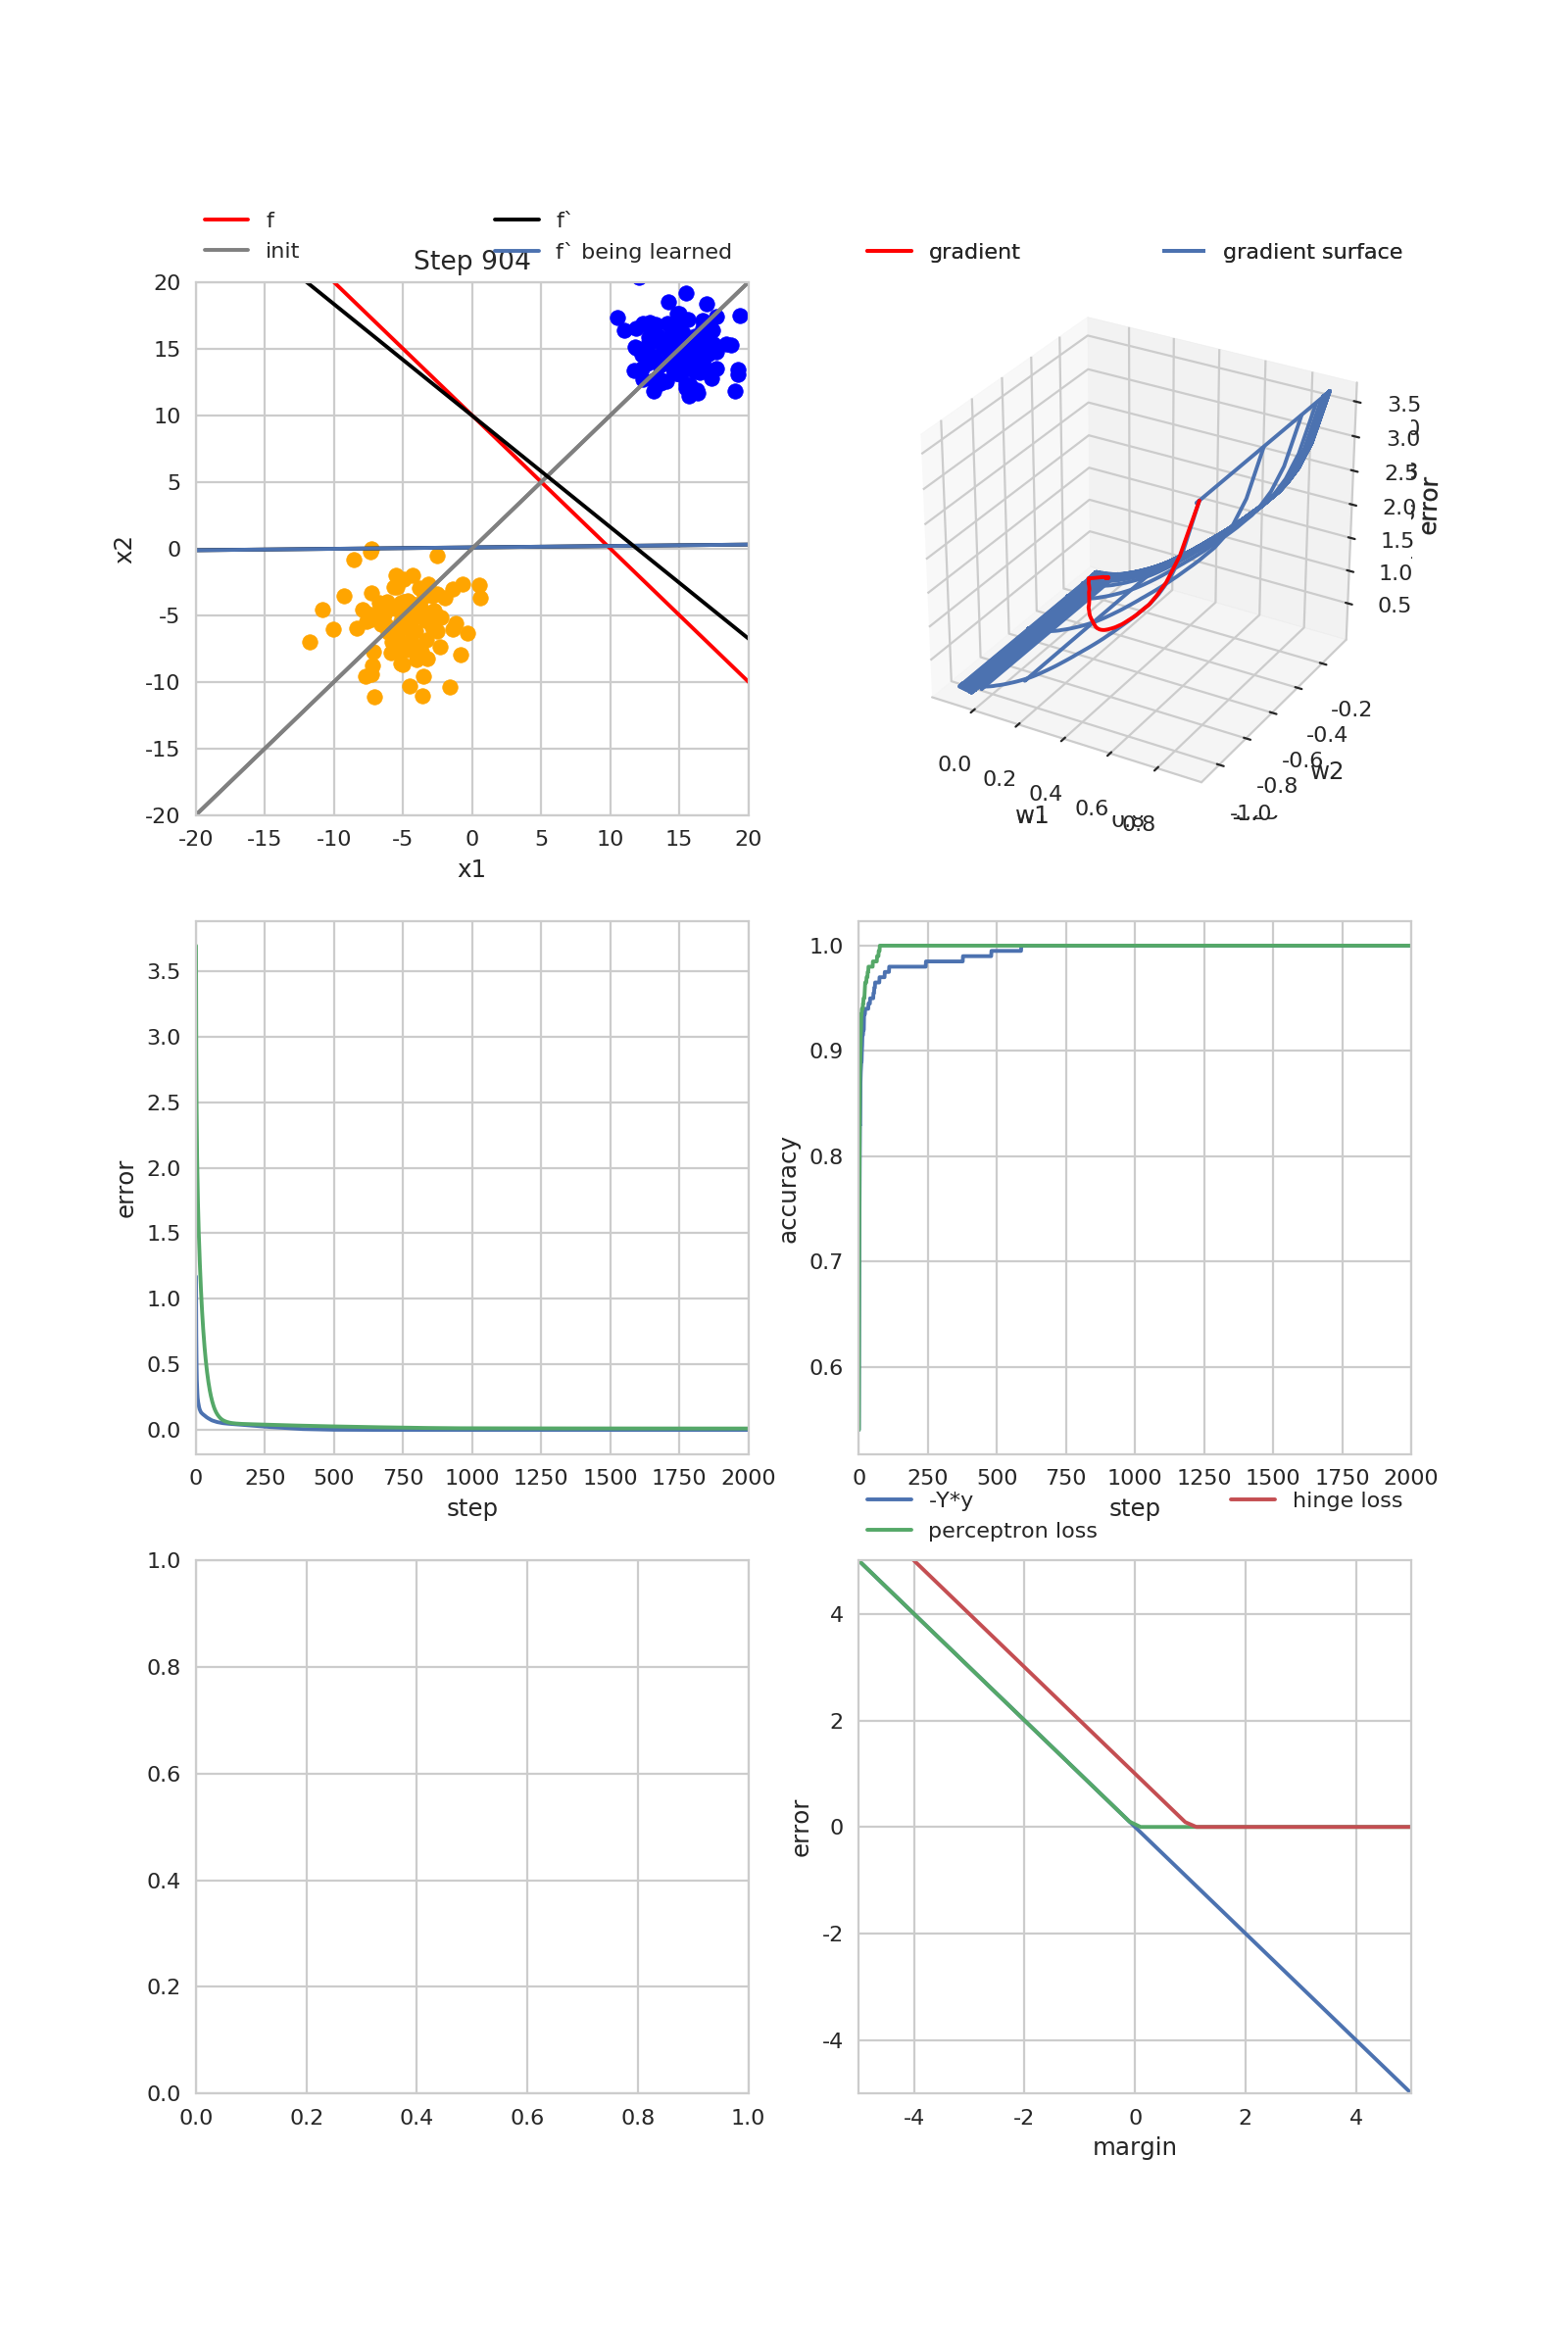

In [7]:
fig, [[ax1,ax2],[ax3,ax4],[_,_]] = plt.subplots(nrows=3,ncols=2,figsize=(10,15),dpi=80)

ax1.set_ylim(-20,20)
ax1.set_xlim(-20,20)
ax1.set_xlabel("x1")
ax1.set_ylabel("x2")

x = np.linspace(-8000,8000,100)
ax1.plot(x,-x+10,label = 'f',c='red')
ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
ax1.scatter(class1[:,0],class1[:,1],c='orange',)
ax1.scatter(class2[:,0],class2[:,1],c='blue')

ax2.axis('off')
_.set_xlabel("margin")
_.set_ylabel("error")

margin = np.linspace(-10,10,100)
_.set_ylim(-5,5)
_.set_xlim(-5,5)
_.plot(margin,-margin,label='-Y*y')
_.plot(margin,np.maximum(0,-margin),label='perceptron loss')
_.plot(margin,np.maximum(0,1-margin),label='hinge loss')
_.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

In [12]:
train = np.concatenate([class1,class2],0)
np.random.shuffle(train)

train[:5]

array([[-11.76187928,  -7.0447481 ,   1.        ],
       [ 19.36881947,  17.46742688,  -1.        ],
       [ 15.7322572 ,  13.94837876,  -1.        ],
       [ -5.38574427,  -4.57109674,   1.        ],
       [ -4.51181731,  -5.0763399 ,   1.        ]])

In [13]:
train_X = train[:,:2]
train_Y = train[:,2]

### hyper parameter 입력

In [14]:
def binary_activation(x):
    cond = tf.less(x, tf.zeros(tf.shape(x)))
    out = tf.where(cond, -tf.ones(tf.shape(x)), tf.ones(tf.shape(x)))
    return out

In [15]:
learning_rate = 0.01
epoch = 2000

### tesorflow symbol 선언

In [16]:
X = tf.placeholder(tf.float32,shape =[None,2])
Y = tf.placeholder(tf.float32,shape =[None,1])

W = tf.Variable([[1.0],
                 [-1.0]])
b = tf.Variable(tf.zeros([1]))

### symbol 관계정의

In [25]:
f = tf.add(tf.matmul(X,W),b)
accuracy = tf.reduce_mean(tf.cast(tf.equal(binary_activation(f),Y),tf.float32))

#error = tf.reduce_mean(tf.maximum(0.0,1-Y*f)) # hinge loss
#error = tf.reduce_mean(tf.maximum(0.0,-Y*f)) # perceptron loss
#error = tf.reduce_mean(-Y*f) # not use max
error = tf.reduce_sum(tf.square(W))+tf.reduce_mean(tf.maximum(0.0,1-Y*f))
#error = tf.losses.hinge_loss(Y,f)
        

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(error)

### seesion 정의 및 실행

In [26]:
w_list = []
b_list = []
error_list = []
acc_list = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    init_w = sess.run(W)
    init_b = sess.run(b)
    
    ax1.plot(x,-(init_w[0]*x+init_b)/init_w[1],label='init',c='gray')
    
    w_list.append([init_w[0][0],init_w[1][0]])
    b_list.append(init_b[0])
    
    for step in range(epoch):
        
        _,weight,bias, cost_val,acc_val = sess.run([train_op,W,b, error, accuracy], 
                                       feed_dict={X: train_X, Y: train_Y.reshape(len(train_Y),1)})
        
        print("step: ",step,"\tw1, w2: ",weight[0],weight[1],"\tb: ",bias,"\terror: ", cost_val,"\tacc: ",acc_val)
        
        w_list.append([weight[0][0],weight[1][0]])
        b_list.append(bias[0])
        error_list.append(cost_val)
        acc_list.append(acc_val)
        
        
    ax1.plot(x,-(w_list[-1][0]*x+bias[-1])/w_list[-1][1],label='f`',c='black')
    
    
    # 최적화가 완료된 모델에 테스트 값을 넣고 결과가 잘 나오는지 확인해봅니다.
#     print("\n=== Test ===")
#     print("X:, ",test)
#     print("Y:", sess.run(f, feed_dict={X: test}))

step:  0 	w1, w2:  [ 0.9120096] [-1.03684044] 	b:  [-0.0007] 	error:  3.695 	acc:  0.54
step:  1 	w1, w2:  [ 0.84520727] [-1.05329823] 	b:  [-0.00065] 	error:  2.90423 	acc:  0.685
step:  2 	w1, w2:  [ 0.79298455] [-1.05736828] 	b:  [  4.99999733e-05] 	error:  2.49144 	acc:  0.775
step:  3 	w1, w2:  [ 0.74998462] [-1.05445147] 	b:  [ 0.0011] 	error:  2.24639 	acc:  0.83
step:  4 	w1, w2:  [ 0.71483749] [-1.04601502] 	b:  [ 0.00245] 	error:  2.07607 	acc:  0.88
step:  5 	w1, w2:  [ 0.6808486] [-1.03733337] 	b:  [ 0.0037] 	error:  1.94732 	acc:  0.885
step:  6 	w1, w2:  [ 0.65139443] [-1.02597809] 	b:  [ 0.0051] 	error:  1.83318 	acc:  0.9
step:  7 	w1, w2:  [ 0.62430972] [-1.01359332] 	b:  [ 0.0066] 	error:  1.73722 	acc:  0.915
step:  8 	w1, w2:  [ 0.59928733] [-1.00035381] 	b:  [ 0.00805] 	error:  1.65103 	acc:  0.92
step:  9 	w1, w2:  [ 0.57652432] [-0.98616844] 	b:  [ 0.00945] 	error:  1.57222 	acc:  0.935
step:  10 	w1, w2:  [ 0.55627888] [-0.97074699] 	b:  [ 0.01055] 	error:  1.50

step:  138 	w1, w2:  [-0.09826861] [-0.15226154] 	b:  [ 0.1047999] 	error:  0.0499832 	acc:  1.0
step:  139 	w1, w2:  [-0.09884435] [-0.15116842] 	b:  [ 0.1055999] 	error:  0.0497619 	acc:  1.0
step:  140 	w1, w2:  [-0.09940858] [-0.15009716] 	b:  [ 0.10639989] 	error:  0.0495468 	acc:  1.0
step:  141 	w1, w2:  [-0.09996153] [-0.14904733] 	b:  [ 0.10719989] 	error:  0.0493377 	acc:  1.0
step:  142 	w1, w2:  [-0.10050341] [-0.14801849] 	b:  [ 0.10799989] 	error:  0.0491343 	acc:  1.0
step:  143 	w1, w2:  [-0.10103446] [-0.14701024] 	b:  [ 0.10879989] 	error:  0.0489364 	acc:  1.0
step:  144 	w1, w2:  [-0.10155489] [-0.14602214] 	b:  [ 0.10959989] 	error:  0.0487438 	acc:  1.0
step:  145 	w1, w2:  [-0.10206492] [-0.14505382] 	b:  [ 0.11039989] 	error:  0.0485564 	acc:  1.0
step:  146 	w1, w2:  [-0.10256473] [-0.14410485] 	b:  [ 0.11119989] 	error:  0.0483738 	acc:  1.0
step:  147 	w1, w2:  [-0.10305455] [-0.14317487] 	b:  [ 0.11199988] 	error:  0.0481959 	acc:  1.0
step:  148 	w1, w2:  [

step:  301 	w1, w2:  [-0.10058194] [-0.11482576] 	b:  [ 0.23515032] 	error:  0.036667 	acc:  1.0
step:  302 	w1, w2:  [-0.10048485] [-0.11468908] 	b:  [ 0.23590033] 	error:  0.0366079 	acc:  1.0
step:  303 	w1, w2:  [-0.1003897] [-0.11455514] 	b:  [ 0.23665033] 	error:  0.0365489 	acc:  1.0
step:  304 	w1, w2:  [-0.10029646] [-0.11442389] 	b:  [ 0.23740034] 	error:  0.0364899 	acc:  1.0
step:  305 	w1, w2:  [-0.10020509] [-0.11429525] 	b:  [ 0.23815034] 	error:  0.0364311 	acc:  1.0
step:  306 	w1, w2:  [-0.10011554] [-0.11416919] 	b:  [ 0.23890035] 	error:  0.0363724 	acc:  1.0
step:  307 	w1, w2:  [-0.10002778] [-0.11404565] 	b:  [ 0.23965035] 	error:  0.0363138 	acc:  1.0
step:  308 	w1, w2:  [-0.09994178] [-0.11392458] 	b:  [ 0.24040036] 	error:  0.0362553 	acc:  1.0
step:  309 	w1, w2:  [-0.09985749] [-0.11380593] 	b:  [ 0.24115036] 	error:  0.0361968 	acc:  1.0
step:  310 	w1, w2:  [-0.0997749] [-0.11368965] 	b:  [ 0.24190037] 	error:  0.0361385 	acc:  1.0
step:  311 	w1, w2:  [-

step:  441 	w1, w2:  [-0.08830943] [-0.100283] 	b:  [ 0.3357003] 	error:  0.0291685 	acc:  1.0
step:  442 	w1, w2:  [-0.08819493] [-0.10000522] 	b:  [ 0.33635029] 	error:  0.029121 	acc:  1.0
step:  443 	w1, w2:  [-0.08809836] [-0.10005071] 	b:  [ 0.33705029] 	error:  0.0290729 	acc:  1.0
step:  444 	w1, w2:  [-0.08798809] [-0.09977758] 	b:  [ 0.33770028] 	error:  0.0290245 	acc:  1.0
step:  445 	w1, w2:  [-0.08789565] [-0.09982762] 	b:  [ 0.33840027] 	error:  0.0289775 	acc:  1.0
step:  446 	w1, w2:  [-0.08778943] [-0.09955894] 	b:  [ 0.33905026] 	error:  0.0289285 	acc:  1.0
step:  447 	w1, w2:  [-0.08770097] [-0.09961335] 	b:  [ 0.33975026] 	error:  0.0288824 	acc:  1.0
step:  448 	w1, w2:  [-0.08759864] [-0.09934897] 	b:  [ 0.34040025] 	error:  0.0288331 	acc:  1.0
step:  449 	w1, w2:  [-0.08751399] [-0.09940758] 	b:  [ 0.34110025] 	error:  0.0287874 	acc:  1.0
step:  450 	w1, w2:  [-0.0874154] [-0.09914731] 	b:  [ 0.34175023] 	error:  0.028738 	acc:  1.0
step:  451 	w1, w2:  [-0.0

step:  598 	w1, w2:  [-0.07661253] [-0.08505139] 	b:  [ 0.43670017] 	error:  0.0224194 	acc:  1.0
step:  599 	w1, w2:  [-0.07655866] [-0.08490169] 	b:  [ 0.43730018] 	error:  0.0223808 	acc:  1.0
step:  600 	w1, w2:  [-0.07650585] [-0.08475499] 	b:  [ 0.43790019] 	error:  0.0223422 	acc:  1.0
step:  601 	w1, w2:  [-0.07645411] [-0.08461121] 	b:  [ 0.4385002] 	error:  0.0223038 	acc:  1.0
step:  602 	w1, w2:  [-0.0764034] [-0.08447032] 	b:  [ 0.43910021] 	error:  0.0222655 	acc:  1.0
step:  603 	w1, w2:  [-0.07636935] [-0.08464995] 	b:  [ 0.43975019] 	error:  0.0222286 	acc:  1.0
step:  604 	w1, w2:  [-0.07632033] [-0.08450828] 	b:  [ 0.4403502] 	error:  0.0221907 	acc:  1.0
step:  605 	w1, w2:  [-0.07627229] [-0.08436944] 	b:  [ 0.44095021] 	error:  0.0221524 	acc:  1.0
step:  606 	w1, w2:  [-0.07622522] [-0.08423338] 	b:  [ 0.44155023] 	error:  0.0221143 	acc:  1.0
step:  607 	w1, w2:  [-0.07617909] [-0.08410004] 	b:  [ 0.44215024] 	error:  0.0220762 	acc:  1.0
step:  608 	w1, w2:  [-

step:  751 	w1, w2:  [-0.06498676] [-0.07580568] 	b:  [ 0.52535039] 	error:  0.0171208 	acc:  1.0
step:  752 	w1, w2:  [-0.06460703] [-0.07569303] 	b:  [ 0.52585042] 	error:  0.0170843 	acc:  1.0
step:  753 	w1, w2:  [-0.06479327] [-0.0757305] 	b:  [ 0.5264504] 	error:  0.0170587 	acc:  1.0
step:  754 	w1, w2:  [-0.06478319] [-0.07561887] 	b:  [ 0.52700037] 	error:  0.0170226 	acc:  1.0
step:  755 	w1, w2:  [-0.06440753] [-0.07550997] 	b:  [ 0.52750039] 	error:  0.0169921 	acc:  1.0
step:  756 	w1, w2:  [-0.06459776] [-0.07555109] 	b:  [ 0.52810037] 	error:  0.0169642 	acc:  1.0
step:  757 	w1, w2:  [-0.06459159] [-0.07544304] 	b:  [ 0.52865034] 	error:  0.0169297 	acc:  1.0
step:  758 	w1, w2:  [-0.06421977] [-0.07533766] 	b:  [ 0.52915037] 	error:  0.0169005 	acc:  1.0
step:  759 	w1, w2:  [-0.06422117] [-0.07523388] 	b:  [ 0.52970034] 	error:  0.0168696 	acc:  1.0
step:  760 	w1, w2:  [-0.06422254] [-0.07513218] 	b:  [ 0.53025031] 	error:  0.0168383 	acc:  1.0
step:  761 	w1, w2:  [

step:  918 	w1, w2:  [-0.05581474] [-0.07388005] 	b:  [ 0.60815012] 	error:  0.0128412 	acc:  1.0
step:  919 	w1, w2:  [-0.05513035] [-0.07335503] 	b:  [ 0.60850012] 	error:  0.01284 	acc:  1.0
step:  920 	w1, w2:  [-0.05546128] [-0.07370645] 	b:  [ 0.60890013] 	error:  0.0128374 	acc:  1.0
step:  921 	w1, w2:  [-0.0556591] [-0.0738797] 	b:  [ 0.60925013] 	error:  0.0128058 	acc:  1.0
step:  922 	w1, w2:  [-0.05497782] [-0.07335468] 	b:  [ 0.60960013] 	error:  0.0127909 	acc:  1.0
step:  923 	w1, w2:  [-0.0553118] [-0.07370611] 	b:  [ 0.61000013] 	error:  0.0127985 	acc:  1.0
step:  924 	w1, w2:  [-0.05551261] [-0.07387936] 	b:  [ 0.61035013] 	error:  0.0127703 	acc:  1.0
step:  925 	w1, w2:  [-0.05549248] [-0.07394766] 	b:  [ 0.61065012] 	error:  0.0127569 	acc:  1.0
step:  926 	w1, w2:  [-0.05547275] [-0.0740146] 	b:  [ 0.61095011] 	error:  0.0127474 	acc:  1.0
step:  927 	w1, w2:  [-0.05545341] [-0.07408019] 	b:  [ 0.6112501] 	error:  0.0127379 	acc:  1.0
step:  928 	w1, w2:  [-0.05

step:  1063 	w1, w2:  [-0.05543992] [-0.07538342] 	b:  [ 0.63999867] 	error:  0.0120935 	acc:  1.0
step:  1064 	w1, w2:  [-0.05516332] [-0.07510247] 	b:  [ 0.64019865] 	error:  0.0120952 	acc:  1.0
step:  1065 	w1, w2:  [-0.05551111] [-0.07546363] 	b:  [ 0.64034867] 	error:  0.0120827 	acc:  1.0
step:  1066 	w1, w2:  [-0.05523309] [-0.07518107] 	b:  [ 0.64054865] 	error:  0.0120924 	acc:  1.0
step:  1067 	w1, w2:  [-0.05496062] [-0.07490417] 	b:  [ 0.64074862] 	error:  0.0120729 	acc:  1.0
step:  1068 	w1, w2:  [-0.05531247] [-0.0752693] 	b:  [ 0.64089864] 	error:  0.0120888 	acc:  1.0
step:  1069 	w1, w2:  [-0.05503841] [-0.07499063] 	b:  [ 0.64109862] 	error:  0.0120705 	acc:  1.0
step:  1070 	w1, w2:  [-0.0553887] [-0.07535402] 	b:  [ 0.64124864] 	error:  0.0120776 	acc:  1.0
step:  1071 	w1, w2:  [-0.05511313] [-0.07507366] 	b:  [ 0.64144862] 	error:  0.0120679 	acc:  1.0
step:  1072 	w1, w2:  [-0.05546192] [-0.07543539] 	b:  [ 0.64159864] 	error:  0.0120668 	acc:  1.0
step:  1073 

step:  1146 	w1, w2:  [-0.05593077] [-0.07603179] 	b:  [ 0.65469843] 	error:  0.0118322 	acc:  1.0
step:  1147 	w1, w2:  [-0.05564435] [-0.07573787] 	b:  [ 0.65489841] 	error:  0.0118336 	acc:  1.0
step:  1148 	w1, w2:  [-0.05598252] [-0.07608632] 	b:  [ 0.65504843] 	error:  0.0118232 	acc:  1.0
step:  1149 	w1, w2:  [-0.05569506] [-0.07579131] 	b:  [ 0.6552484] 	error:  0.0118297 	acc:  1.0
step:  1150 	w1, w2:  [-0.05603222] [-0.0761387] 	b:  [ 0.65539843] 	error:  0.0118144 	acc:  1.0
step:  1151 	w1, w2:  [-0.05574377] [-0.07584264] 	b:  [ 0.6555984] 	error:  0.0118257 	acc:  1.0
step:  1152 	w1, w2:  [-0.05607996] [-0.076189] 	b:  [ 0.65574843] 	error:  0.0118057 	acc:  1.0
step:  1153 	w1, w2:  [-0.05579055] [-0.07589193] 	b:  [ 0.6559484] 	error:  0.0118216 	acc:  1.0
step:  1154 	w1, w2:  [-0.05550694] [-0.07560081] 	b:  [ 0.65614837] 	error:  0.0118005 	acc:  1.0
step:  1155 	w1, w2:  [-0.05584786] [-0.075952] 	b:  [ 0.6562984] 	error:  0.0118139 	acc:  1.0
step:  1156 	w1, w2

step:  1231 	w1, w2:  [-0.05617912] [-0.07631429] 	b:  [ 0.66969824] 	error:  0.0115712 	acc:  1.0
step:  1232 	w1, w2:  [-0.05650659] [-0.07665121] 	b:  [ 0.66984826] 	error:  0.0115636 	acc:  1.0
step:  1233 	w1, w2:  [-0.05620866] [-0.0763449] 	b:  [ 0.67004824] 	error:  0.0115661 	acc:  1.0
step:  1234 	w1, w2:  [-0.05653554] [-0.07668121] 	b:  [ 0.67019826] 	error:  0.0115564 	acc:  1.0
step:  1235 	w1, w2:  [-0.05623703] [-0.07637431] 	b:  [ 0.67039824] 	error:  0.0115608 	acc:  1.0
step:  1236 	w1, w2:  [-0.05656334] [-0.07671003] 	b:  [ 0.67054826] 	error:  0.0115492 	acc:  1.0
step:  1237 	w1, w2:  [-0.05626427] [-0.07640254] 	b:  [ 0.67074823] 	error:  0.0115556 	acc:  1.0
step:  1238 	w1, w2:  [-0.05659004] [-0.0767377] 	b:  [ 0.67089826] 	error:  0.0115421 	acc:  1.0
step:  1239 	w1, w2:  [-0.05629044] [-0.07642967] 	b:  [ 0.67109823] 	error:  0.0115502 	acc:  1.0
step:  1240 	w1, w2:  [-0.05661569] [-0.07676428] 	b:  [ 0.67124826] 	error:  0.0115351 	acc:  1.0
step:  1241 

step:  1314 	w1, w2:  [-0.05669446] [-0.07684913] 	b:  [ 0.68424815] 	error:  0.0113131 	acc:  1.0
step:  1315 	w1, w2:  [-0.05701163] [-0.07717535] 	b:  [ 0.68439817] 	error:  0.011311 	acc:  1.0
step:  1316 	w1, w2:  [-0.05670359] [-0.07685856] 	b:  [ 0.68459815] 	error:  0.0113067 	acc:  1.0
step:  1317 	w1, w2:  [-0.05702058] [-0.0771846] 	b:  [ 0.68474817] 	error:  0.0113052 	acc:  1.0
step:  1318 	w1, w2:  [-0.05671237] [-0.07686762] 	b:  [ 0.68494815] 	error:  0.0113003 	acc:  1.0
step:  1319 	w1, w2:  [-0.05702918] [-0.07719348] 	b:  [ 0.68509817] 	error:  0.0112994 	acc:  1.0
step:  1320 	w1, w2:  [-0.05672079] [-0.07687633] 	b:  [ 0.68529814] 	error:  0.0112938 	acc:  1.0
step:  1321 	w1, w2:  [-0.05703744] [-0.07720201] 	b:  [ 0.68544817] 	error:  0.0112936 	acc:  1.0
step:  1322 	w1, w2:  [-0.05672888] [-0.07688469] 	b:  [ 0.68564814] 	error:  0.0112873 	acc:  1.0
step:  1323 	w1, w2:  [-0.05704536] [-0.0772102] 	b:  [ 0.68579817] 	error:  0.0112878 	acc:  1.0
step:  1324 	

step:  1469 	w1, w2:  [-0.05956305] [-0.07600271] 	b:  [ 0.70310098] 	error:  0.0110679 	acc:  1.0
step:  1470 	w1, w2:  [-0.05913461] [-0.07555716] 	b:  [ 0.703251] 	error:  0.0110676 	acc:  1.0
step:  1471 	w1, w2:  [-0.05933359] [-0.07575701] 	b:  [ 0.70335102] 	error:  0.011075 	acc:  1.0
step:  1472 	w1, w2:  [-0.0595286] [-0.07595287] 	b:  [ 0.70345104] 	error:  0.0110661 	acc:  1.0
step:  1473 	w1, w2:  [-0.05910084] [-0.07550831] 	b:  [ 0.70360106] 	error:  0.0110586 	acc:  1.0
step:  1474 	w1, w2:  [-0.05930051] [-0.07570914] 	b:  [ 0.70370108] 	error:  0.0110731 	acc:  1.0
step:  1475 	w1, w2:  [-0.05949618] [-0.07590596] 	b:  [ 0.7038011] 	error:  0.0110642 	acc:  1.0
step:  1476 	w1, w2:  [-0.05968793] [-0.07609884] 	b:  [ 0.70390111] 	error:  0.0110555 	acc:  1.0
step:  1477 	w1, w2:  [-0.05925699] [-0.07565136] 	b:  [ 0.70405114] 	error:  0.0110652 	acc:  1.0
step:  1478 	w1, w2:  [-0.05945353] [-0.07584933] 	b:  [ 0.70415115] 	error:  0.0110627 	acc:  1.0
step:  1479 	w1

step:  1608 	w1, w2:  [-0.06010755] [-0.07633252] 	b:  [ 0.71905363] 	error:  0.0108914 	acc:  1.0
step:  1609 	w1, w2:  [-0.06028708] [-0.07651687] 	b:  [ 0.71915364] 	error:  0.0108836 	acc:  1.0
step:  1610 	w1, w2:  [-0.05984415] [-0.07606103] 	b:  [ 0.71930367] 	error:  0.0108815 	acc:  1.0
step:  1611 	w1, w2:  [-0.06002895] [-0.07625081] 	b:  [ 0.71940368] 	error:  0.010891 	acc:  1.0
step:  1612 	w1, w2:  [-0.06021005] [-0.07643679] 	b:  [ 0.7195037] 	error:  0.0108831 	acc:  1.0
step:  1613 	w1, w2:  [-0.06038753] [-0.07661905] 	b:  [ 0.71960372] 	error:  0.0108754 	acc:  1.0
step:  1614 	w1, w2:  [-0.0599426] [-0.07616118] 	b:  [ 0.71975374] 	error:  0.0108839 	acc:  1.0
step:  1615 	w1, w2:  [-0.06012542] [-0.07634895] 	b:  [ 0.71985376] 	error:  0.0108828 	acc:  1.0
step:  1616 	w1, w2:  [-0.06030459] [-0.07653297] 	b:  [ 0.71995378] 	error:  0.010875 	acc:  1.0
step:  1617 	w1, w2:  [-0.05986132] [-0.07607682] 	b:  [ 0.7201038] 	error:  0.010871 	acc:  1.0
step:  1618 	w1,

step:  1717 	w1, w2:  [-0.06059156] [-0.07681715] 	b:  [ 0.73145568] 	error:  0.0107496 	acc:  1.0
step:  1718 	w1, w2:  [-0.06076141] [-0.0769918] 	b:  [ 0.7315557] 	error:  0.0107424 	acc:  1.0
step:  1719 	w1, w2:  [-0.060309] [-0.07652647] 	b:  [ 0.73170573] 	error:  0.0107386 	acc:  1.0
step:  1720 	w1, w2:  [-0.0604845] [-0.07670694] 	b:  [ 0.73180574] 	error:  0.01075 	acc:  1.0
step:  1721 	w1, w2:  [-0.06065648] [-0.0768838] 	b:  [ 0.73190576] 	error:  0.0107427 	acc:  1.0
step:  1722 	w1, w2:  [-0.06082503] [-0.07705712] 	b:  [ 0.73200577] 	error:  0.0107357 	acc:  1.0
step:  1723 	w1, w2:  [-0.06037135] [-0.07659049] 	b:  [ 0.7321558] 	error:  0.0107377 	acc:  1.0
step:  1724 	w1, w2:  [-0.0605456] [-0.07676967] 	b:  [ 0.73225582] 	error:  0.0107432 	acc:  1.0
step:  1725 	w1, w2:  [-0.06071637] [-0.07694528] 	b:  [ 0.73235583] 	error:  0.0107361 	acc:  1.0
step:  1726 	w1, w2:  [-0.06088372] [-0.07711737] 	b:  [ 0.73245585] 	error:  0.0107291 	acc:  1.0
step:  1727 	w1, w2:

step:  1826 	w1, w2:  [-0.061256] [-0.07749908] 	b:  [ 0.74375772] 	error:  0.0106033 	acc:  1.0
step:  1827 	w1, w2:  [-0.0607937] [-0.07702361] 	b:  [ 0.74390775] 	error:  0.010602 	acc:  1.0
step:  1828 	w1, w2:  [-0.0609595] [-0.07719413] 	b:  [ 0.74400777] 	error:  0.010611 	acc:  1.0
step:  1829 	w1, w2:  [-0.06112199] [-0.07736125] 	b:  [ 0.74410778] 	error:  0.0106044 	acc:  1.0
step:  1830 	w1, w2:  [-0.06128123] [-0.07752502] 	b:  [ 0.7442078] 	error:  0.010598 	acc:  1.0
step:  1831 	w1, w2:  [-0.06081843] [-0.07704902] 	b:  [ 0.74435782] 	error:  0.0105977 	acc:  1.0
step:  1832 	w1, w2:  [-0.06098374] [-0.07721904] 	b:  [ 0.74445784] 	error:  0.0106056 	acc:  1.0
step:  1833 	w1, w2:  [-0.06114574] [-0.07738566] 	b:  [ 0.74455786] 	error:  0.0105991 	acc:  1.0
step:  1834 	w1, w2:  [-0.06130451] [-0.07754894] 	b:  [ 0.74465787] 	error:  0.0105927 	acc:  1.0
step:  1835 	w1, w2:  [-0.06084123] [-0.07707247] 	b:  [ 0.7448079] 	error:  0.0105931 	acc:  1.0
step:  1836 	w1, w2

step:  1943 	w1, w2:  [-0.06294759] [-0.07616691] 	b:  [ 0.75345933] 	error:  0.0105101 	acc:  1.0
step:  1944 	w1, w2:  [-0.06303583] [-0.07622004] 	b:  [ 0.75350934] 	error:  0.0105087 	acc:  1.0
step:  1945 	w1, w2:  [-0.06312231] [-0.07627211] 	b:  [ 0.75355935] 	error:  0.0105074 	acc:  1.0
step:  1946 	w1, w2:  [-0.06320706] [-0.07632314] 	b:  [ 0.75360936] 	error:  0.0105062 	acc:  1.0
step:  1947 	w1, w2:  [-0.06267125] [-0.07573666] 	b:  [ 0.75370938] 	error:  0.0105065 	acc:  1.0
step:  1948 	w1, w2:  [-0.06335264] [-0.07646731] 	b:  [ 0.75370938] 	error:  0.0105322 	acc:  1.0
step:  1949 	w1, w2:  [-0.06281392] [-0.07587794] 	b:  [ 0.75380939] 	error:  0.0105218 	acc:  1.0
step:  1950 	w1, w2:  [-0.06349247] [-0.07660577] 	b:  [ 0.75380939] 	error:  0.0105122 	acc:  1.0
step:  1951 	w1, w2:  [-0.06295095] [-0.07601363] 	b:  [ 0.75390941] 	error:  0.0105365 	acc:  1.0
step:  1952 	w1, w2:  [-0.06303913] [-0.07606983] 	b:  [ 0.75395942] 	error:  0.0105073 	acc:  1.0
step:  195

### graph3 error 변화

In [27]:
ax3.set_xlim(0,epoch)
ax3.set_xlabel("step")
ax3.set_ylabel("error")

step = np.linspace(0,epoch,epoch)
ax3.plot(step,error_list)

### graph4 accuracy 변화

In [28]:
ax4.set_xlim(0,epoch)
ax4.set_xlabel("step")
ax4.set_ylabel("accuracy")

step = np.linspace(0,epoch,epoch)
ax4.plot(step,acc_list)

### error surface

In [29]:
ax2 = fig.add_subplot(322, projection='3d')
ax2.set_xlabel("w1")
ax2.set_ylabel("w2")
ax2.set_zlabel("error")

w1, w2 = np.meshgrid(np.array(w_list)[1:,0], np.array(w_list)[1:,1])

In [30]:
ax2.plot_wireframe(w1, w2, error_list,label='gradient surface')
ax2.plot(np.array(w_list)[1:,0], np.array(w_list)[1:,1],error_list,c='red',label='gradient')
ax2.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

### graph1 f\` 변화

In [31]:
def init(w,b):
    line.set_ydata(-(w[0][0]*x+b[0])/w[0][1])
    ax1.set_title('Frame ' + str('0'))
    return line,

def animate(i,w,b):
    line.set_ydata(-(w[i][0]*x+b[i])/w[i][1])
    ax1.set_title('Step ' + str(i))
    return line,

In [24]:
line, = ax1.plot(x,-w_list[0][1]/w_list[0][0]*x + w_list[2][0],label='f` being learned ')
ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
ani = animation.FuncAnimation(fig,animate,np.arange(0,epoch),interval=1,blit=True,fargs=(w_list,b_list))